# Decoding Strategies and Sampling in Text Generation

- Auto-Regressive language generation is based on the assumption that the probability distribution of a word sequence can be decomposed into the product of conditional next word distributions.
- $P_{(w_{1:T}|W_0)} = \prod_{t=1}^{T}P(w_t|w_{1:t-1}, W_0)$, with $w_{1:0} = \phi$
where,
$W_0$ = Initial context word sequence
$T$ = Length of the word sequence
$t=T$ correspondes to timestamp

## Decoding Strategies

### Greedy Search Decoding

- Greedy Search is simplest decoding method.
- It selects the word with highest probability as its next word: $w_t = argmax_wP(w|w_{1:t11})$ at each timestamp $t$.
- The major drawback of greedy search is that it misses high probability words hidden behind an inital low probability word.

In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

In [3]:
# Set up device
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
# Set model
model_name = "gpt2-xl"

In [5]:
# Get Tokenizer and Model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

In [6]:
import pandas as pd

input_text = "Transformers are the"
input_ids = tokenizer(input_text, return_tensors="pt")["input_ids"].to(device)
iterations = []
n_steps = 10
choices_per_step = 5

with torch.no_grad():
    for _ in range(n_steps):
        iteration = dict()
        iteration['Input'] = tokenizer.decode(input_ids[0])
        output = model(input_ids=input_ids)
        # Select logits of of the first batch and the last token and apply softmax
        next_token_logits = output.logits[0, -1, :]
        next_token_probs = torch.softmax(next_token_logits, dim=-1)
        sorted_ids = torch.argsort(next_token_probs, dim=-1, descending=True)
        # Store tokens with highest probabilities
        for choice_idx in range(choices_per_step):
            token_id = sorted_ids[choice_idx]
            token_prob = next_token_probs[token_id].cpu().numpy()
            token_choice = (
                f"{tokenizer.decode(token_id)} ({100 * token_prob:.2f}%)"
            )
            iteration[f'Choice {choice_idx+1}'] = token_choice
        # Append predicted next token to input
        input_ids = torch.cat([input_ids, sorted_ids[None, 0, None]], dim=-1)
        iterations.append(iteration)

pd.DataFrame(iterations)

,Input,Choice 1,Choice 2,Choice 3,Choice 4,Choice 5
0,Transformers are the,most (8.53%),only (4.96%),best (4.65%),Transformers (4.37%),ultimate (2.16%)
1,Transformers are the most,popular (16.78%),powerful (5.37%),common (4.96%),famous (3.72%),successful (3.20%)
2,Transformers are the most popular,toy (10.63%),toys (7.23%),Transformers (6.60%),of (5.46%),and (3.76%)
3,Transformers are the most popular toy,line (34.38%),in (18.20%),of (11.71%),brand (6.10%),line (2.69%)
4,Transformers are the most popular toy line,in (46.28%),of (15.09%),", (4.94%)",on (4.40%),ever (2.72%)
5,Transformers are the most popular toy line in,the (65.99%),history (12.42%),America (6.91%),Japan (2.44%),North (1.40%)
6,Transformers are the most popular toy line in the,world (69.27%),United (4.55%),history (4.29%),US (4.23%),U (2.30%)
7,Transformers are the most popular toy line in ...,", (39.73%)",. (30.64%),and (9.87%),with (2.32%),today (1.74%)
8,Transformers are the most popular toy line in ...,and (32.51%),with (18.66%),but (8.06%),so (5.42%),having (2.19%)
9,Transformers are the most popular toy line in ...,the (11.70%),they (7.48%),it (6.24%),for (3.06%),I (2.97%)


In [7]:
# Using Generate function
input_ids = tokenizer(input_text, return_tensors="pt")["input_ids"].to(device)
output = model.generate(input_ids, max_new_tokens=n_steps, do_sample=False)
print(tokenizer.decode(output[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Transformers are the most popular toy line in the world, and the


### Beam Search Decoding

- Beam search reduces the risk of missing hidden high probability word sequences by keeping the most likely `num_beams` of hypotheses at each time stamp and eventually choosing the hypothesis that has the overall highest probability.
- Beam Search will always find an output sequence with higher probability than greedy search, but is not guaranteed to find the most likely output.

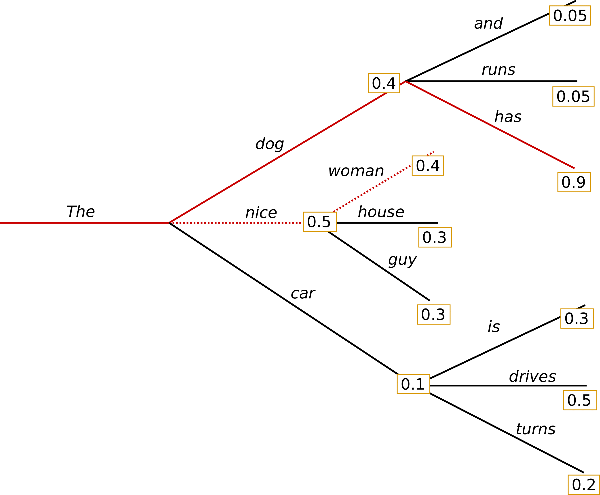

In [10]:
import torch.nn.functional as F

In [15]:
# Create log probabilities from unnormalized logits for a single token
def log_probs_from_logits(logits, labels):
    logp = F.log_softmax(logits, dim=-1)
    logp_label = torch.gather(logp, 2, labels.unsqueeze(2)).squeeze(-1)
    return logp_label

In [16]:
# Create log probabilities for whole sequence
def sequence_logprob(model, labels, input_len=0):
    with torch.no_grad():
        output = model(labels)
        log_probs = log_probs_from_logits(
            output.logits[:, :-1, :], labels[:, 1:])
        seq_log_prob = torch.sum(log_probs[:, input_len:])
    return seq_log_prob.cpu().numpy()

In [13]:
max_length = 128
input_txt = """In a shocking finding, scientist discovered \
a herd of unicorns living in a remote, previously unexplored \
valley, in the Andes Mountains. Even more surprising to the \
researchers was the fact that the unicorns spoke perfect English.\n\n
"""
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output_greedy = model.generate(
    input_ids, 
    max_length=max_length,
    do_sample=False)
print(tokenizer.decode(output_greedy[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The researchers, from the University of California, Davis, and the University of Colorado, Boulder, were conducting a study on the Andean cloud forest, which is home to the rare species of cloud forest trees.


The researchers were surprised to find that the unicorns were able to communicate with each other, and even with humans.


The researchers were surprised to find that the unicorns were able


In [17]:
logp = sequence_logprob(model, output_greedy, input_len=len(input_ids[0]))
print(tokenizer.decode(output_greedy[0]))
print(f"\nlog-prob: {logp:.2f}")

In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The researchers, from the University of California, Davis, and the University of Colorado, Boulder, were conducting a study on the Andean cloud forest, which is home to the rare species of cloud forest trees.


The researchers were surprised to find that the unicorns were able to communicate with each other, and even with humans.


The researchers were surprised to find that the unicorns were able

log-prob: -87.43


In [18]:
# Use Beam Search
output_beam = model.generate(
    input_ids, 
    max_length=max_length, 
    num_beams=5, 
    do_sample=False)
logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f"\nlog-prob: {logp:.2f}")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The discovery of the unicorns was made by a team of scientists from the University of California, Santa Cruz, and the National Geographic Society.


The scientists were conducting a study of the Andes Mountains when they discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English

log-prob: -55.23


## Sampling Methods

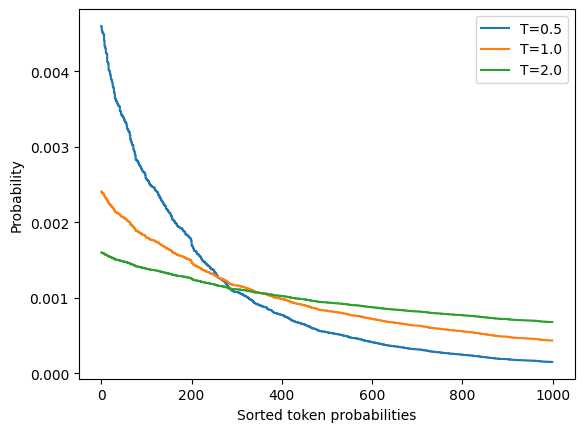

In [19]:
import matplotlib.pyplot as plt
import numpy as np

def softmax(logits, T=1):
    e_x = np.exp(logits / T)
    return e_x / e_x.sum()

logits = np.exp(np.random.random(1000))
sorted_logits = np.sort(logits)[::-1]
x = np.arange(1000)

for T in [0.5, 1.0, 2.0]:
    plt.step(x, softmax(sorted_logits, T), label=f"T={T}")
plt.legend(loc="best")
plt.xlabel("Sorted token probabilities")
plt.ylabel("Probability")
plt.show()

In [20]:
torch.manual_seed(31415926)
output_temp = model.generate(input_ids, max_length=max_length, do_sample=True, 
                             temperature=2.0, top_k=0)
print(tokenizer.decode(output_temp[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


Crowned rings on unicorn belonged unknown pepper sprayed other bitesuj286ca10715 Beaver section shuttle Ontario lanes routetemitizcil horse cogautoWorking cities 00 Queens central drowningpmThanksPerfectNational Soci frequentHopefully) Cold Real Tracks 183NS329 dazzthia 392rerac Vie 91 Orange Pricatics turtles<|endoftext|>


In [21]:
output_temp = model.generate(input_ids, max_length=max_length, do_sample=True, 
                             temperature=0.5, top_k=0)
print(tokenizer.decode(output_temp[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The researchers, from the University of New Mexico, studied the unicorns' behavior, lifestyle, and language. They found that the unicorns' language is a form of a language called "hylotl", which was first discovered in the Andes Mountains in the early 1900s.

The researchers studied the unicorns' behavior, lifestyle, and language. They found that the unicorns'


In [22]:
# hide
input_txt = """In a shocking finding, scientist discovered \
a herd of unicorns living in a remote, previously unexplored \
valley, in the Andes Mountains. Even more surprising to the \
researchers was the fact that the unicorns spoke perfect English.\n\n
"""
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)

with torch.no_grad():
    output = model(input_ids=input_ids)
    next_token_logits = output.logits[:, -1, :]
    probs = F.softmax(next_token_logits, dim=-1).detach().cpu().numpy()

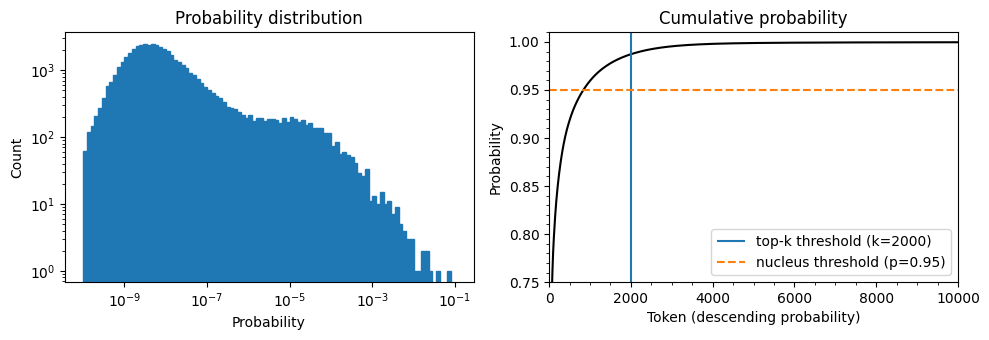

In [23]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))

axes[0].hist(probs[0], bins=np.logspace(-10, -1, 100), color="C0", edgecolor="C0")
axes[0].set_xscale("log")
axes[0].set_yscale("log")
axes[0].set_title("Probability distribution")
axes[0].set_xlabel("Probability")
axes[0].set_ylabel("Count")
#axes[0].grid(which="major")

axes[1].plot(np.cumsum(np.sort(probs[0])[::-1]), color="black")
axes[1].set_xlim([0, 10000])
axes[1].set_ylim([0.75, 1.01])
axes[1].set_title("Cumulative probability")
axes[1].set_ylabel("Probability")
axes[1].set_xlabel("Token (descending probability)")
#axes[1].grid(which="major")
axes[1].minorticks_on()
#axes[1].grid(which='minor', linewidth='0.5')
top_k_label = 'top-k threshold (k=2000)'
top_p_label = 'nucleus threshold (p=0.95)'
axes[1].vlines(x=2000, ymin=0, ymax=2, color='C0', label=top_k_label)
axes[1].hlines(y=0.95, xmin=0, xmax=10000, color='C1', label=top_p_label, linestyle='--')
axes[1].legend(loc='lower right')
plt.tight_layout()

In [24]:
output_topk = model.generate(input_ids, max_length=max_length, do_sample=True, 
                             top_k=50)
print(tokenizer.decode(output_topk[0]))
     

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


"The majority of the animals we found seem to fit that pattern; they're very social, they eat meat and they are herbivores. However, what is unusual about these animals is that the ones we saw were very rare. We saw about ten, and one had a tooth missing," Dr. Jiri Vlachogianni said, adding that they didn't know how many unicorns


In [25]:
output_topp = model.generate(input_ids, max_length=max_length, do_sample=True, 
                             top_p=0.90)
print(tokenizer.decode(output_topp[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The scientists have dubbed these creatures as 'Uruk-Hai' which means 'Uruk's horses' in the ancient language.


It was found the unicorns live in the valley that is just 15 feet above sea level in the Sierra Nevada, and are believed to be the only herd of these majestic creatures in the region.


The researchers used a technique called optically stimulated
